# Algorithme PageRank

In [1]:
import re, sys
from operator import add
import numpy as np
import pandas as pd
from math import *
import os
os.chdir("C:/Users/brian/Documents/ENSAE/3A/ELDTM/Pagerank")
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Algorithme

Calcul du rang pour chaque noeud :

$$r^{i+1}(p)=\sum_{ q \rightarrow p}\frac{r^{i}(q)}{d(q)}$$

In [2]:
def liste_contrib(nums,rang):
    #poids de chaque noeud dans l'ensemble des numéros sortant
    nb_nums=len(nums)
    for num in nums:
        yield (num,rang/nb_nums)

Introduction du facteur d'amortissement $\alpha$ pour le calcul du rang selon la formule :

$$r^{i+1}(p)=\frac{1-\alpha}{N}+\alpha \sum_{ q \rightarrow p}\frac{r^{i}(q)}{d(q)}$$

Itérations sur le calcul du rang :

In [3]:
def calcul_rang_final(liens,nb_iter_max,epsilon,alpha,memoire_noeuds):
    nb_iter=0
    nb_noeuds=liens.distinct().count()
    rangs = liens.map(lambda num_voisin: (num_voisin[0], 1/nb_noeuds))  #initialisation du rang de chaque noeud
    moyennes_diff_rang=[]
    max_diff_rang=[]
    p_converge=[]
    if memoire_noeuds:#pour voir évolution du pagerank par noeud
        memoire=pd.DataFrame(rangs.collect(),columns=['index',0]).set_index('index',drop=True)
    while nb_iter<nb_iter_max:
        contribs = liens.join(rangs).flatMap( lambda x: liste_contrib(x[1][0], x[1][1]))  #calcul contribution de chacun
        nouv_rangs = contribs.reduceByKey(add).mapValues(lambda rang: rang * alpha + (1-alpha)/nb_noeuds) #nouveaux rangs
        diff_rang = rangs.join(nouv_rangs).map(lambda score : abs(score[1][1]-score[1][0])/score[1][0]) #calcul du taux de variation du rang
        liste_diff_rang=diff_rang.collect()
        moyennes_diff_rang.append(np.mean(liste_diff_rang))
        max_diff_rang.append(max(liste_diff_rang))
        p_converge.append(sum(i<epsilon for i in liste_diff_rang)/len(liste_diff_rang))
        nb_iter+=1
        if memoire_noeuds:
            memoire_nouv=pd.DataFrame(nouv_rangs.collect(),columns=['index',nb_iter]).set_index('index',drop=True)
            memoire=pd.merge(memoire,memoire_nouv,left_index=True,right_index=True)
        rangs=nouv_rangs
    if memoire_noeuds:
        retour=(nouv_rangs,p_converge,moyennes_diff_rang,max_diff_rang,memoire)
    else :
        retour=(nouv_rangs,p_converge,moyennes_diff_rang,max_diff_rang)
    return retour

## Création d'un petit jeu de données

Création de la base test

In [4]:
liens_test=[('1','2'),('1','3'),('1','4'),
      ('2','3'),('2','4'),
      ('3','4'),
      ('4','1')]
liens_df=pd.DataFrame(liens_test,columns=['num','num_sortant'])
liens_test=sc.parallelize(liens_test).distinct().groupByKey().cache()

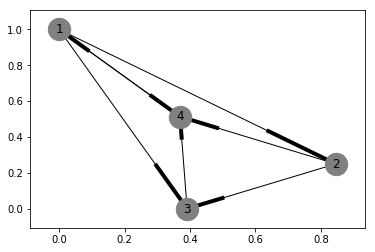

In [7]:
graphe=nx.from_pandas_dataframe(liens_df, 'num', 'num_sortant',create_using=nx.DiGraph())
graphe=nx.draw_networkx(graphe, node_color = 'grey', node_size = 500,arrows=True)
plt.savefig('Output/graphe.png')

## Implémentation sur le jeu petit jeu de données

Choix des paramètres

In [8]:
alpha=0.85
eps=1e-3
nb_iter=5
memoire_noeuds=True

Implémentation de l'algorithme

In [9]:
nouv_rangs_test,p_converge_test,moyennes_diff_rang_test,max_diff_rang_test,memoire=calcul_rang_final(liens_test,nb_iter,eps,alpha,memoire_noeuds)

Vérification des sorties

In [11]:
nouv_rangs_test.collect()

[('3', 0.18209947410300928),
 ('2', 0.12717645109953704),
 ('4', 0.346487371238426),
 ('1', 0.3442367035590278)]

On représente le grahique des moyennes des taux de variations (en rouge) et du maximum des taux de variation pour chaque itération :

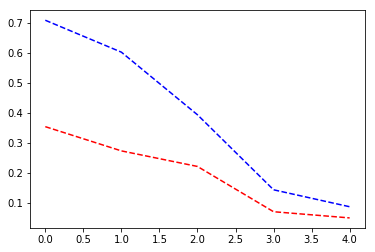

In [12]:
liste=[i for i in range(len(moyennes_diff_rang_test))]
plt.plot(liste,moyennes_diff_rang_test,"r--",liste,max_diff_rang_test,"b--")
plt.show()

In [13]:
memoire

,0,1,2,3,4,5
index,,,,,,
3,0.25,0.214583,0.154375,0.197023,0.193398,0.182099
2,0.25,0.108333,0.108333,0.150981,0.129231,0.127176
4,0.25,0.427083,0.336771,0.328241,0.360867,0.346487
1,0.25,0.250000,0.400521,0.323755,0.316505,0.344237


In [14]:
memoire.to_csv('memoire.csv',header=True, index=None)

## Chargement du jeu de données réel

On récupère une base de données web sur le site http://snap.stanford.edu. On passe par pandas pour enlever les premières lignes correspondant à des commentaires. On enlève par ailleurs les noeuds qui n'ont aucun lien sortant.

In [15]:
df = pd.read_csv("web-Stanford.txt", sep="\t",names=['num','num_sortant'] ,encoding="utf-8",skiprows=[0,1,2,3])#2312497 lignes
liste_noeuds=df['num'].unique()
df2=df[df.num_sortant.isin(liste_noeuds)]#2312087 lignes
df2.to_csv("web-Stanford2.txt", sep="\t", encoding="utf-8", index=False, header=None)

In [16]:
def coupler(nums):
    #fonction pour parser les données
    couple = re.split(r'\t', nums)
    return couple[0], couple[1]

Chargement sur spark

In [17]:
base = sc.textFile("web-Stanford2.txt",1)  
liens = base.map(lambda nums: coupler(nums)).distinct().groupByKey().cache()

## Implémentation de l'algorithme sur le jeu de données réel

Choix des paramètres

In [18]:
alpha=0.85
eps=1e-3
nb_iter=20
memoire=False

Implémentation de l'algorithme

In [19]:
nouv_rangs,p_converge,moyennes_diff_rang,max_diff_rang=calcul_rang_final(liens,nb_iter,eps,alpha,memoire)

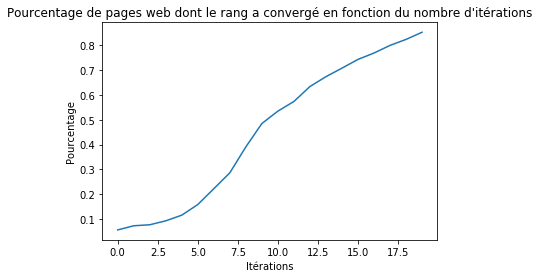

In [20]:
import matplotlib.pyplot as plt
plt.plot(p_converge)
plt.title("Pourcentage de pages web dont le rang a convergé en fonction du nombre d'itérations")
plt.ylabel('Pourcentage')
plt.xlabel('Itérations')
plt.savefig('Output/pourcentage_reel.png')
plt.show()

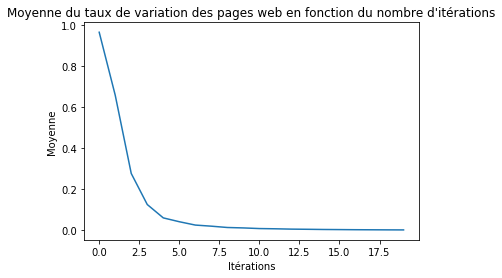

In [21]:
plt.plot(moyennes_diff_rang)
plt.title("Moyenne du taux de variation des pages web en fonction du nombre d'itérations")
plt.ylabel('Moyenne')
plt.xlabel('Itérations')
plt.savefig('Output/moyenne_reel.png')
plt.show()

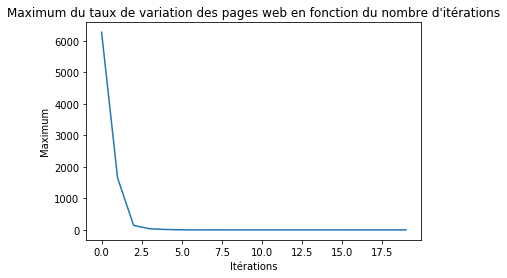

In [22]:
plt.plot(max_diff_rang)
plt.title("Maximum du taux de variation des pages web en fonction du nombre d'itérations")
plt.ylabel('Maximum')
plt.xlabel('Itérations')
plt.savefig('Output/max_reel.png')
plt.show()

In [23]:
liste=nouv_rangs.collect()

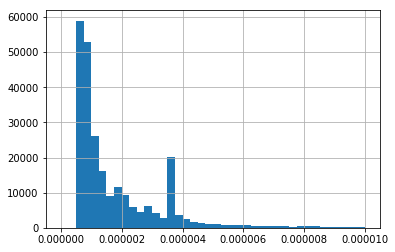

In [28]:
pd.DataFrame(liste)[1].hist(bins=40, range=(0,0.00001))
plt.savefig('Output/hist_val.png')